In [0]:
# Import Libraries
import json
import random
import os
import re
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
import pandas as pd
import gensim
import numpy as np
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from statistics import mode 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.keyedvectors import KeyedVectors
import re
from scipy.spatial import distance
import string
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, LSTM
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, Activation, Flatten
from keras.models import Model
from keras.initializers import Constant
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [0]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot
import html
from scipy.spatial import distance
from wordcloud import WordCloud

In [901]:
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

# Use English stemmer.
word_stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()
nltk_eng_stop_words = stopwords.words('english')
custom_stop_words = ['of','the','a','to','is','in','on', 'that', 'an', 'by', 'for']

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/develop_inferencia_ai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/develop_inferencia_ai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/develop_inferencia_ai/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Fetch the dataset from my github (https://github.com/kakumanu-sudhir/covid19/tree/master/dataset). Data is extracted from PIB twitter handle with small corpus.

In [0]:
# factcheck_data_df = pd.read_csv('https://raw.githubusercontent.com/kakumanu-sudhir/covid19/master/dataset/mygovfactcheck_data.csv')

# PIB is having the data as per our need
pib_factcheck_data_df = pd.read_csv('https://raw.githubusercontent.com/kakumanu-sudhir/covid19/master/dataset/pibfactcheck_data.csv')

In [903]:
pib_factcheck_data_df.head(1)

,Unnamed: 0,entities.urls,created_at,full_text,claim_text,fact_text,user.name,user.id,id,lang,real_fact
0,0.0,[],2020-05-22 13:49:57+00:00,Claim-@Rohini_sgh claims in @thewire_in that t...,Claim-@Rohini_sgh claims in @thewire_in that t...,#PIBFactCheck-#FakeNews According to Govt of G...,PIB Fact Check,1.207630e+18,1.263830e+18,en,False


In [0]:
# toi_17_18_whatsapp_articles_df = pd.read_csv('https://raw.githubusercontent.com/sahitpj/India-WhatsAppFakeNews-Dataset/master/data.csv')

In [0]:
# toi_17_18_whatsapp_articles_df.head(2)

In [0]:
def decontracted(phrase):
    phrase = html.unescape(phrase)
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"govt", " government", phrase)
    return phrase

In [0]:
# clean the data and get it transformed as needed
def get_cleaned_data(input_data, mode='df', stop_words = None, tokenize_op=True):
    input_df = ''
    
    if mode != 'df':
        input_df = pd.DataFrame([input_data], columns=['text'])
    else:
        input_df = input_data
        
    #lowercase the text
    input_df['text'] = input_df['text'].str.lower().str.strip()

    input_df['text'] = input_df['text'].apply(lambda elem: decontracted(elem))
    
    #remove @mentions of twitter
    # input_df['text'] = input_df['text'].apply(lambda elem: re.sub(r"@[\w]*", "", elem))

    #replace newline with space
    input_df['text'] = input_df['text'].apply(lambda elem: elem.replace('\n', ' ').strip())

    #remove special characters
    input_df['text'] = input_df['text'].apply(lambda elem: re.sub(r"(#[A-Za-z0-9]+)|(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", " ", elem))
    
    #reduce multiple spaces to one space
    input_df['text'] = input_df['text'].replace('\s+', ' ', regex=True)

    # remove numbers
    # input_df['text'] = input_df['text'].apply(lambda elem: re.sub(r"\d+", "", elem))
    
    #remove stopwords
    if stop_words is not None:      
      input_df['text'] = input_df['text'].apply(lambda x: ' '.join([word.strip() for word in x.split() if word not in (stop_words)]))
    
    #stemming, changes the word to root form
    # input_df['text'] = input_df['text'].apply(lambda words: ' '.join([word_stemmer.stem(word) for word in words]))
    
    #lemmatization, same as stemmer, but language corpus is used to fetch the root form, so resulting words make sense
#     more description @ https://www.datacamp.com/community/tutorials/stemming-lemmatization-python
    input_df['text'] = input_df['text'].apply(lambda words: (wordnet_lemmatizer.lemmatize(words)))
    
    if tokenize_op == True:
      input_df['text'] = input_df['text'].apply(lambda row: word_tokenize(row))

    return input_df

In [0]:
def get_pretrained_model():
  # model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300', binary=True, limit=500000)
  wv_from_bin = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True, limit=500000) 
  #extracting word vectors from google news vector
  embeddings_index = {}
  for word, vector in zip(wv_from_bin.vocab, wv_from_bin.vectors):
      coefs = np.asarray(vector, dtype='float32')
      embeddings_index[word] = coefs
  
  return embeddings_index

In [0]:
#Define text representation method here
def get_embedding_matrix(words, model, num_features):

    embedding_matrix = np.zeros((num_features, EMBEDDING_DIM))
    for word, i in words.items():
        try:
            embedding_vector = model[word]
            embedding_matrix[i] = embedding_vector
        except KeyError:
            embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

    return embedding_matrix

In [0]:
def cnn_net1():
    model = Sequential()

    #Non-trainable embeddidng layer
    model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=128, kernel_size=4, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.2))
    model.add(Dense(units = 128 , activation = 'relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [0]:
def lstm_net1():
    model = Sequential()

    #Non-trainable embeddidng layer
    model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    
    model.add(LSTM(units=128 , return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64))
    model.add(Dropout(0.1))
    model.add(Dense(units = 32 , activation = 'relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [0]:
def get_pred_output(text_to_check):
    sequences = tokenizer.texts_to_sequences([text_to_check])
    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    predicted_val = model.predict_classes(data)
#     predicted_val = model.predict(data)    
#     if predicted_val.max() > 0.7:
#         output = 1
#     else:
#         output = 0
    return predicted_val

In [0]:
def results_test_function(tokenizer, model, stop_w=None):
  test_messages_dict = [
                        {'real_fact': True, 'text': 'Lockdown 3.0: Glance through the Safety measures applicable Nationally irrespective of the Zone. #IndiaFightsCorona https://t.co/nkmSQc9m9I https://t.co/ixDCSzmwb2'}, 
                        {'real_fact': True, 'text': 'Now access your EPFO account using UMANG. You can register, check status, apply &amp; track claim and download your EPFO passbook, all from your mobile, from wherever you are. Visit https://t.co/TvcRXTtp8i for more details. #IndiaFightsCorona @UmangOfficial_ https://t.co/xAcObs70K9'}, 
                        {'real_fact': True, 'text': 'Feeling bored during this lockdown? We are here with a solution. To test your knowledge, take the quiz on COVID-19 and become a Corona Warrior. Let’s spread awareness and disseminate the right information about COVID-19 amongst Citizens. #IndiaFightsCorona https://t.co/EgqEzfNJHv https://t.co/4nWAUD57WF'},
                        {'real_fact': False, 'text': ' News Portal http://Dailyexcelsior.com reports J&K students "stranded" in Delhi due to #Lockdown were told to arrange buses for themselves by college administration'},
                        {'real_fact': False, 'text': 'An audio message is shared on social media claiming that central govt is giving Rs 3 lakh per #COVID19 patient to State Govts to look after patient '},
                        {'real_fact': False, 'text': 'Governments roadmap to ease covid-10 restriction will be on 3 week review process, the current phases would commence on the following dates: Phase 1 - 18th May Phase 2 - 8th June Phase 3 - 29th June Phase 4 - 20th July Phase 5 - 10th August If coronavirus cases begin to increase, we will revert to restrictions set out in the previous stage'},
                        {'real_fact': False, 'text': 'A whatsapp message circulating with links of Google forms titled ‘RESCUE FLIGHTS FROM  INDIA’ for stranded people is not issued by the Government. '},
                        {'real_fact': False, 'text': 'The workers who worked between the 1990 and 2020, have the right to receive the benefit of 120000 from Ministry of Labour and Employment, Check if your name is in the list of people who have the rights to withdraw this benefits'},
                        {'real_fact': False, 'text': 'Entire Mumbai military lockdown for 10 days from Saturday please stock everything Only milk and medicine will be available'}
                        ]
  test_messages_df = pd.DataFrame(test_messages_dict)
  test_messages_df = get_cleaned_data(test_messages_df, tokenize_op=False, stop_words=stop_w)

  sequences = tokenizer.texts_to_sequences(test_messages_df.text)
  data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

  final_test_pred = model.predict_classes(data)
  cf_matrix_test = confusion_matrix(test_messages_df.real_fact,final_test_pred)
  # print('Unseen real data prediction {} '.format(pred[0]))
  sns.heatmap(cf_matrix_test, annot=True, fmt='g', xticklabels = ['Fake','Real'] , yticklabels = ['Fake','Real'])

  return final_test_pred, data

In [0]:
def get_full_corpus(cleaned_df):
  corpus = cleaned_df.text.tolist()
  corpus_tokens = ([word for row in corpus for word in row])
  corpus_all = ' '.join(corpus_tokens)
  
  return corpus_all, corpus_tokens

In [0]:
def show_wordcloud(corpus):
  wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(corpus)
  plt.figure(figsize=(10, 7))
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis('off')
  plt.show()  

In [0]:
def show_freq_dist(corpus_tokens_list):
  b = nltk.FreqDist(corpus_tokens_list)
  e = pd.DataFrame({'words': list(b.keys()), 'Count': list(b.values())})
  # selecting top 20 most frequent hashtags
  e = e.nlargest(columns="Count", n = 20)
  plt.figure(figsize=(16,5))
  ax = sns.barplot(data=e, x= "words", y = "Count")
  ax.set(ylabel = 'Count')
  plt.show()  

In [0]:
def get_w2v_model(dataset):
  num_features = 300  # Word vector dimensionality
  min_word_count = 1 # Minimum word count
  num_workers = 4     # Number of parallel threads
  context = 10        # Context window size
  downsampling = 1e-3 # (0.001) Downsample setting for frequent words

  w2v_model = Word2Vec(dataset.text,\
                            workers=num_workers,\
                            size=num_features,\
                            min_count=min_word_count,\
                            window=context,
                            sample=downsampling)
  
  return w2v_model

In [0]:
def show_pca_components(X):
  pca = PCA(n_components=2)
  result = pca.fit_transform(X)
  pyplot.figure(figsize=(40,20))
  # create a scatter plot of the projection
  pyplot.scatter(result[:, 0], result[:, 1])
  words = list(w2v_model.wv.vocab)
  for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
  pyplot.show()  

In [919]:
pib_factcheck_data_df.head(2)

,Unnamed: 0,entities.urls,created_at,full_text,claim_text,fact_text,user.name,user.id,id,lang,real_fact
0,0.0,[],2020-05-22 13:49:57+00:00,Claim-@Rohini_sgh claims in @thewire_in that t...,Claim-@Rohini_sgh claims in @thewire_in that t...,#PIBFactCheck-#FakeNews According to Govt of G...,PIB Fact Check,1.207630e+18,1.263830e+18,en,False
1,1.0,[],2020-05-21 12:47:05+00:00,RT @PIBAhmedabad: #PIBFactcheck:\nClaim:The Gu...,Claim:The Gujarat Samachar shows figure of 800...,NaN,PIB Fact Check,1.207630e+18,1.263450e+18,en,False


In [0]:
# pib_factcheck_data_df[['created_at', 'full_text', 'real_fact', 'claim_text', 'fact_text']]
fake_text = pib_factcheck_data_df[['created_at', 'claim_text', 'real_fact']]
real_text = pib_factcheck_data_df[['created_at', 'fact_text', 'real_fact']]

In [0]:
fake_text = fake_text.rename(columns={'created_at': 'date', 'claim_text': 'text'})
real_text = real_text.rename(columns={'created_at': 'date', 'fact_text': 'text'})

In [0]:
fake_text['text'] = fake_text['text'].str.lower()
fake_text['text'] = fake_text['text'].str.strip()
fake_text['real_fact'] = False
fake_text.dropna(inplace=True)

real_text['text'] = real_text['text'].str.lower()
real_text['text'] = real_text['text'].str.strip()
real_text['real_fact'] = True
real_text.dropna(inplace=True)


In [0]:
fake_text_cleaned = get_cleaned_data(fake_text, stop_words=custom_stop_words)
real_text_cleaned = get_cleaned_data(real_text, stop_words=custom_stop_words)

In [924]:
# for text in real_text.text:
  # print(text)
print(len(real_text_cleaned[real_text_cleaned.real_fact == True]))
print(len(fake_text_cleaned[fake_text_cleaned.real_fact == False]))

127
118


In [0]:
fake_corpus_all, fake_corpus_tokens = get_full_corpus(fake_text_cleaned)
real_corpus_all, real_corpus_tokens = get_full_corpus(real_text_cleaned)

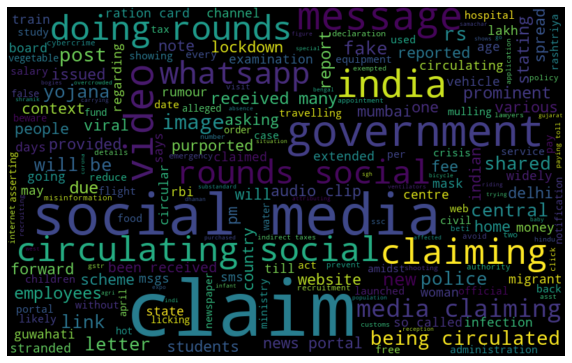

In [926]:
show_wordcloud(fake_corpus_all)

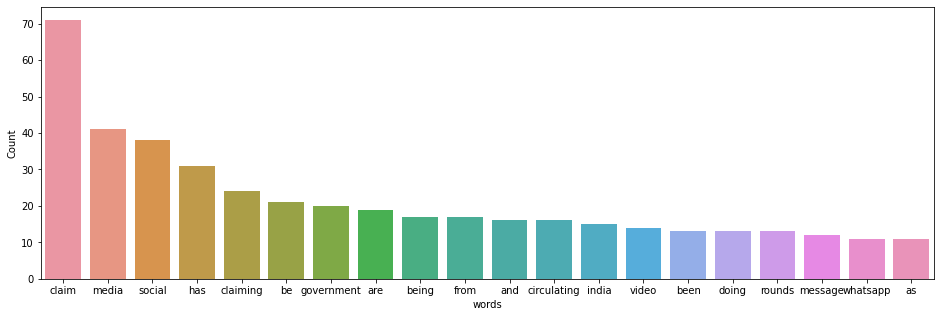

In [927]:
show_freq_dist(fake_corpus_tokens)

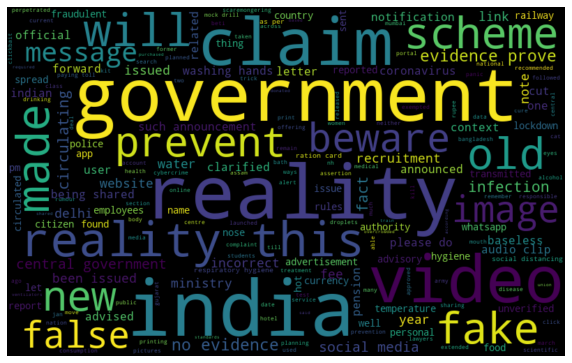

In [928]:
show_wordcloud(real_corpus_all)

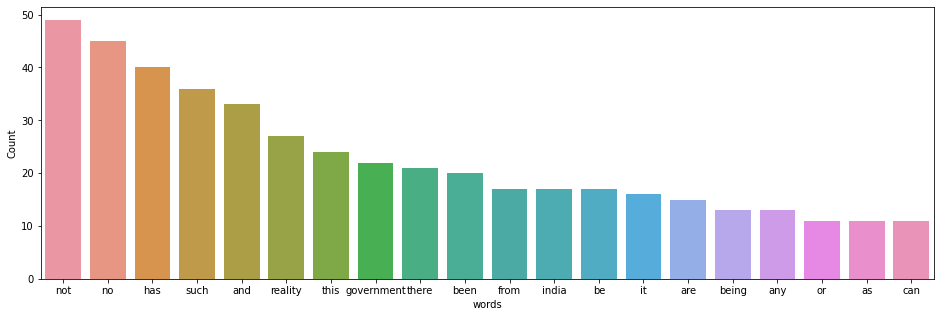

In [929]:
show_freq_dist(real_corpus_tokens)

In [930]:
factcheck_w2v_dataset = pd.concat([real_text_cleaned, fake_text_cleaned], ignore_index = True)
print(factcheck_w2v_dataset.shape)

(245, 3)


In [931]:
w2v_model = get_w2v_model(factcheck_w2v_dataset)
print(w2v_model)

Word2Vec(vocab=1280, size=300, alpha=0.025)


In [932]:
words = list(w2v_model.wv.vocab)
print((words))

['according', 'government', 'gujarat', 'said', 'ventilators', 'were', 'not', 'purchased', 'but', 'donated', 'are', 'based', 'required', 'medical', 'standards', 'image', 'old', 'and', 'from', 'india', 'beware', 'images', 'videos', 'being', 'shared', 'out', 'context', 'this', 'video', 'before', '2016', 'bangladesh', 'it', 'overcrowded', 'train', 'year', '2018', 'forwards', 'union', 'hrd', 'minister', 'will', 'be', 'releasing', 'date', 'sheet', 'same', 'at', '5', 'pm', 'today', 'its', 'there', 'no', 'such', 'announcement', 'fraudulent', 'websites', 'news', 'roadmap', 'made', 'our', 'some', 'other', 'country', 'incorrect', 'university', 'admin', 'has', 'asked', 'students', 'leave', 'arrange', 'their', 'own', 'transport', 'reality', 'claim', 'spokesperson', 'termed', 'irresponsible', 'proposal', 'under', 'consideration', 'any', 'cut', 'salaries', 'false', 'national', 'health', 'authority', 'clarified', 'only', 'official', 'website', 'fact', 'delhi', 'police', 'have', 'denied', 'eight', 'app

In [933]:
X = w2v_model[w2v_model.wv.vocab]
print(X.shape)

(1280, 300)


/home/develop_inferencia_ai/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


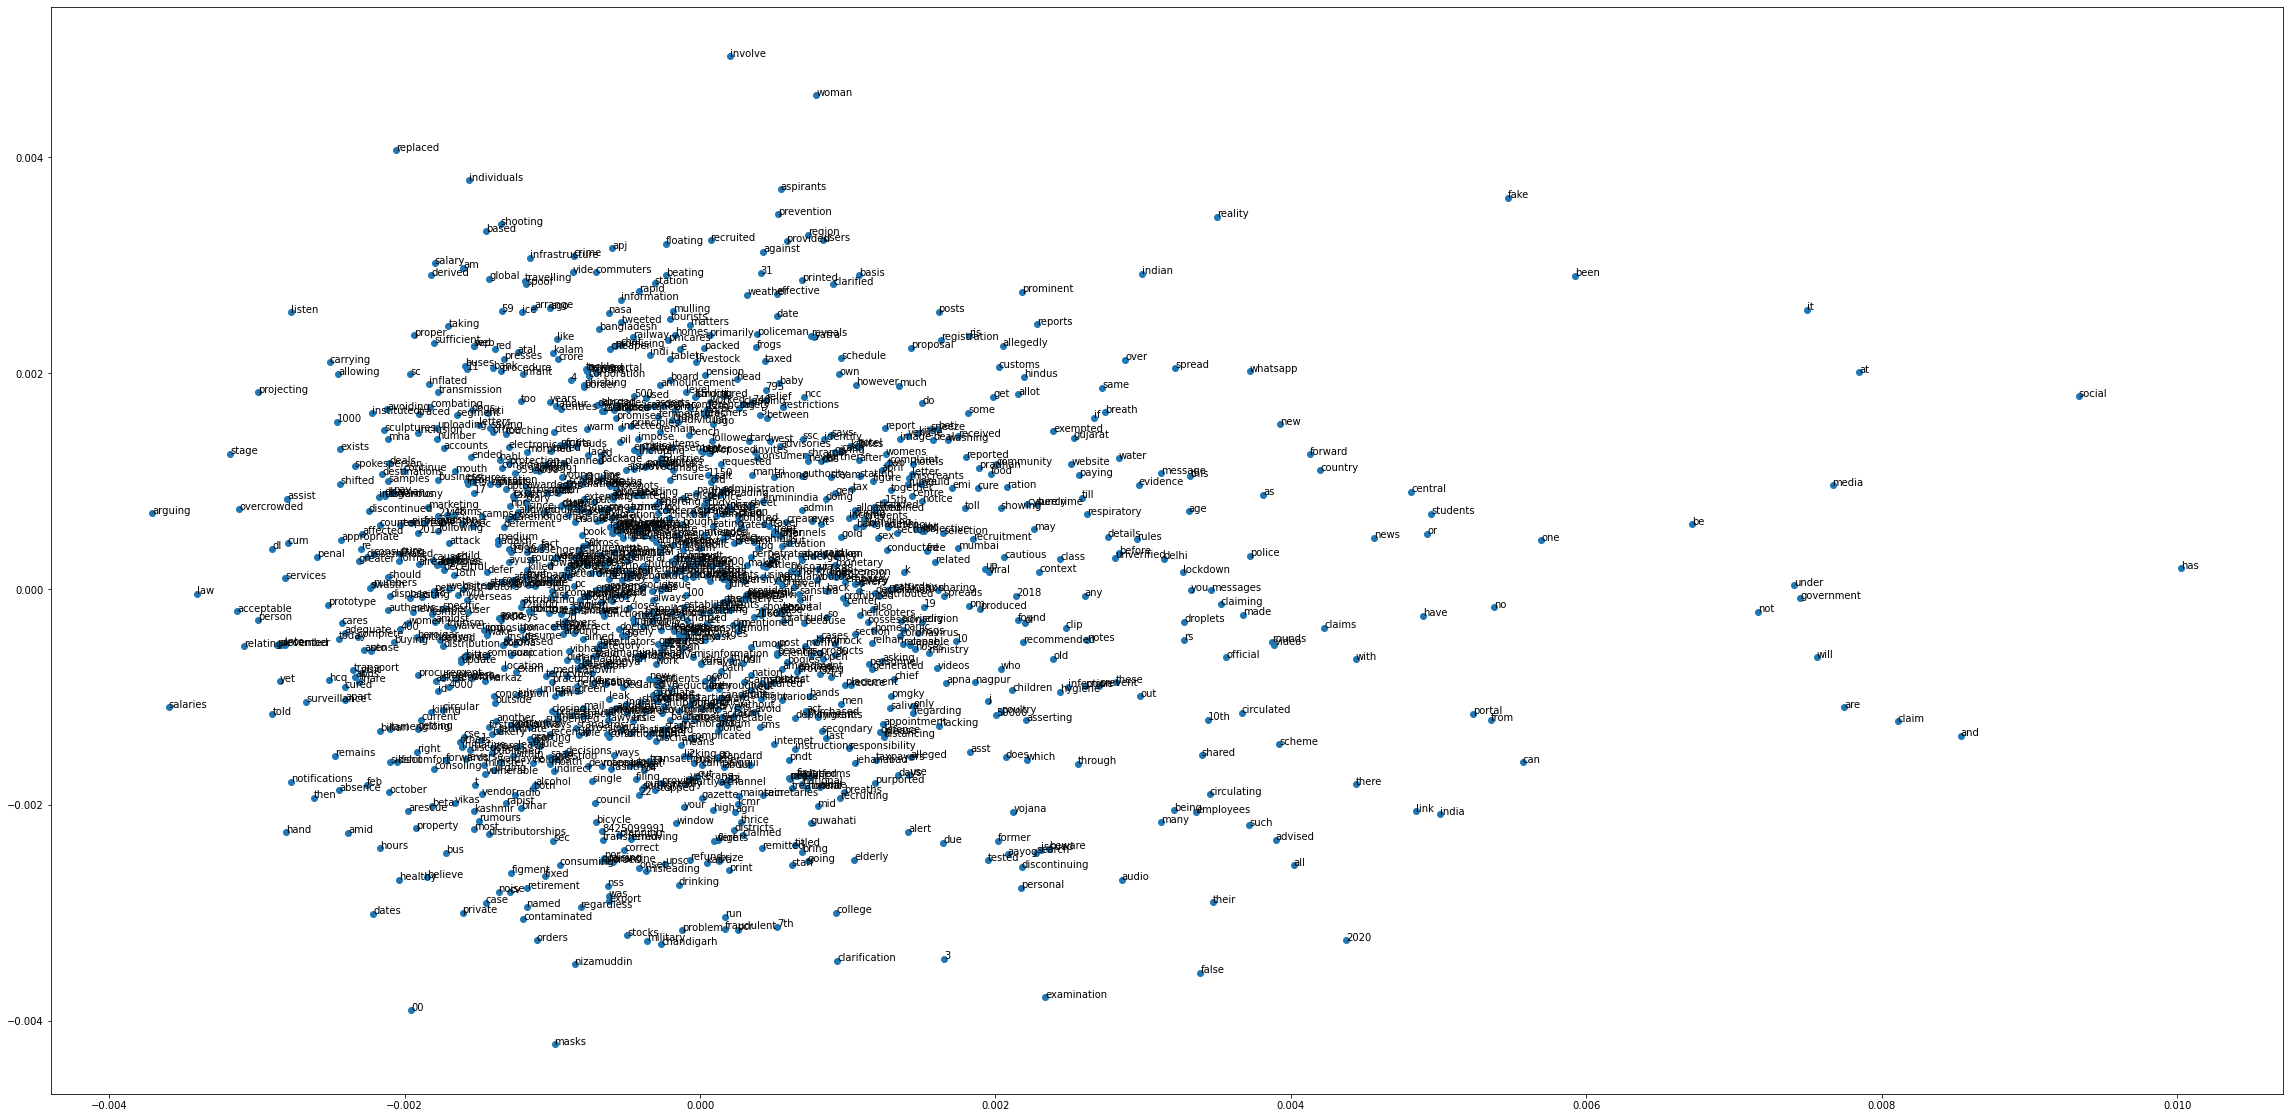

In [934]:
show_pca_components(X)

In [0]:
MAX_SEQUENCE_LENGTH = 300
MAX_NUM_WORDS = 10000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.3

Fetch pre-trained model of Google News vector

In [0]:
embeddings_index = get_pretrained_model()

Peform Training with factcheck dataset alone first and observe the result

In [0]:
x_train_fact,x_test_fact,y_train_fact,y_test_fact = train_test_split(factcheck_w2v_dataset.text,factcheck_w2v_dataset.real_fact,random_state = 42, test_size=VALIDATION_SPLIT, shuffle=True)

In [938]:
tokenizer_factcheck_w2v = Tokenizer(num_words=MAX_NUM_WORDS)

# Updates internal vocabulary based on a list of texts. 
# This method creates the vocabulary index based on word frequency. So if you give it something like, "The cat sat on the mat." 
# It will create a dictionary s.t. word_index["the"] = 1; word_index["cat"] = 2 it is word -> index dictionary so every word gets a unique integer value. 
# So lower integer means more frequent word (often the first few are stop words because they appear a lot).
tokenizer_factcheck_w2v.fit_on_texts(x_train_fact)

word_index_fact = tokenizer_factcheck_w2v.word_index

# Transforms each text in texts to a sequence of integers. 
# So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary.
# sequences = tokenizer.texts_to_sequences(news_data_df.text)
tokenized_train = tokenizer_factcheck_w2v.texts_to_sequences(x_train_fact)
X_train_fact = pad_sequences(tokenized_train, maxlen=MAX_SEQUENCE_LENGTH)

tokenized_test = tokenizer_factcheck_w2v.texts_to_sequences(x_test_fact)
X_test_fact = pad_sequences(tokenized_test, maxlen=MAX_SEQUENCE_LENGTH)

print('Found {} tokens, {} train_data_sentences &  {} test_data_sentences'.format(len(word_index_fact), len(X_train_fact), len(X_test_fact)))

Found 1037 tokens, 171 train_data_sentences &  74 test_data_sentences


In [0]:
vocab_size = len(word_index_fact) + 1
embedding_matrix = get_embedding_matrix(word_index_fact, embeddings_index, vocab_size)
# del embeddings_index

In [940]:
#training an LSTM network
model_fact = lstm_net1()
# model_fact = cnn_net1()

batch_size = 256
epochs = 30

model_fact.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 300, 300)          311400    
_________________________________________________________________
lstm_39 (LSTM)               (None, 300, 128)          219648    
_________________________________________________________________
dropout_43 (Dropout)         (None, 300, 128)          0         
_________________________________________________________________
lstm_40 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_44 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_44 (Dense)             (None, 1)               

In [941]:
history = model_fact.fit(X_train_fact, y_train_fact, batch_size = batch_size , validation_data = (X_test_fact,y_test_fact) , epochs = epochs)

Train on 171 samples, validate on 74 samples
Epoch 1/30
171/171 [==============================] - 2s 13ms/step - loss: 0.6915 - accuracy: 0.5088 - val_loss: 0.6889 - val_accuracy: 0.6216
Epoch 2/30
171/171 [==============================] - 1s 7ms/step - loss: 0.6828 - accuracy: 0.6842 - val_loss: 0.6852 - val_accuracy: 0.7297
Epoch 3/30
171/171 [==============================] - 1s 7ms/step - loss: 0.6741 - accuracy: 0.7544 - val_loss: 0.6798 - val_accuracy: 0.7162
Epoch 4/30
171/171 [==============================] - 1s 7ms/step - loss: 0.6618 - accuracy: 0.8655 - val_loss: 0.6722 - val_accuracy: 0.7297
Epoch 5/30
171/171 [==============================] - 1s 7ms/step - loss: 0.6478 - accuracy: 0.8538 - val_loss: 0.6613 - val_accuracy: 0.7568
Epoch 6/30
171/171 [==============================] - 1s 7ms/step - loss: 0.6249 - accuracy: 0.8889 - val_loss: 0.6473 - val_accuracy: 0.7297
Epoch 7/30
171/171 [==============================] - 1s 7ms/step - loss: 0.5965 - accuracy: 0.9064 - 

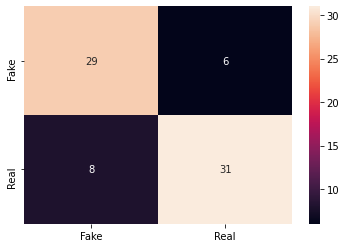

In [942]:
pred = model_fact.predict_classes(X_test_fact)
cf_matrix = confusion_matrix(y_test_fact,pred)
sns.heatmap(cf_matrix, annot=True, fmt='g', xticklabels = ['Fake','Real'] , yticklabels = ['Fake','Real'])

Testing with some real world data

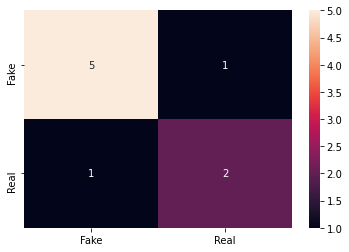

In [943]:
prediction, inp_data = results_test_function(tokenizer_factcheck_w2v, model_fact, stop_w=custom_stop_words)

In [0]:
model_fact.save("fact_check_model_25_5_20.h5")

In [0]:
import pickle

# saving
with open('fact_check_tokenizer_25_5_20.pickle', 'wb') as handle:
    pickle.dump(tokenizer_factcheck_w2v, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [952]:
from keras.models import load_model
import pickle

# loading
with open('fact_check_tokenizer_25_5_20.pickle', 'rb') as handle:
    tokenizer_loaded = pickle.load(handle)

# load model
model_loaded = load_model('fact_check_model_25_5_20.h5')
# summarize model.
model_loaded.summary()


def loaded_model_test_function(tokenizer, model, stop_w=None):
  test_messages_dict = [
                        {'real_fact': False, 'text': 'Governments roadmap to ease covid-10 restriction will be on 3 week review process, the current phases would commence on the following dates: Phase 1 - 18th May Phase 2 - 8th June Phase 3 - 29th June Phase 4 - 20th July Phase 5 - 10th August If coronavirus cases begin to increase, we will revert to restrictions set out in the previous stage'}
                        # {'real_fact': False, 'text': 'The workers who worked between the 1990 and 2020, have the right to receive the benefit of 120000 from Ministry of Labour and Employment, Check if your name is in the list of people who have the rights to withdraw this benefits'},
                        # {'real_fact': False, 'text': 'Entire Mumbai military lockdown for 10 days from Saturday please stock everything Only milk and medicine will be available'}
                        ]
  test_messages_df = pd.DataFrame(test_messages_dict)
  test_messages_df = get_cleaned_data(test_messages_df, tokenize_op=False, stop_words=stop_w)

  sequences = tokenizer.texts_to_sequences(test_messages_df.text)
  data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

  final_test_pred = model.predict_classes(data)
  return final_test_pred, data



Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 300, 300)          311400    
_________________________________________________________________
lstm_39 (LSTM)               (None, 300, 128)          219648    
_________________________________________________________________
dropout_43 (Dropout)         (None, 300, 128)          0         
_________________________________________________________________
lstm_40 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_44 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_44 (Dense)             (None, 1)               

In [953]:
prediction, inp_data = loaded_model_test_function(tokenizer_loaded, model_loaded, stop_w=custom_stop_words)
print(prediction)

[[0]]


[[0]]


Conclusion:
We are able to successfully detect a whatsapp forward message which is written in totally different grammer and phrases

---

Trained Message:
*Claim: A so-called 3-week, 5-phase "roadmap", purportedly made by the Government, to ease #COVID19India restrictions is being circulated on Whatsapp.*

Whatsapp Forward message:
*Governments roadmap to ease covid-10 restriction will be on 3 week review process, the current phases would commence on the following dates: Phase 1 - 18th May Phase 2 - 8th June Phase 3 - 29th June Phase 4 - 20th July Phase 5 - 10th August If coronavirus cases begin to increase, we will revert to restrictions set out in the previous stage*



---

Trained Message:
*Claim: A #WhatsApp forward says there'll be a military lockdown in Mumbai for 10 days, starting from Saturday*

Whatsapp Forward message:
*Entire Mumbai military lockdown for 10 days from Saturday please stock everything Only milk and medicine will be available*


---


 

---



## Lets analyze if the global real vs fake news provides any help for fake forwards in India



---



In [0]:
# search for dataset by name 'fake' in kaggle
# !kaggle datasets list -s fake

In [0]:
# Install kaggle downloader for downloading datasets
# !pip3 install kaggleDownloader
# !pip3 install kaggle

In [0]:
# Download the dataset from kaggle
# from kaggleDownloader import get_dataset
# get_dataset('kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset')

Fetch the Fake and Real news dataset from Kaggle (https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset):

In [0]:
real_news_df = pd.read_csv("./True.csv")
fake_news_df = pd.read_csv("./Fake.csv")

Increase the data with the one from Kaggle and see if we can do better

In [0]:
real_news_df['text'] = real_news_df['title'] + " " + real_news_df['text']
fake_news_df['text'] = fake_news_df['title'] + " " + fake_news_df['text']

In [835]:
print(real_news_df.shape)
print(fake_news_df.shape)
real_news_df = real_news_df[real_news_df['text'].str.len() >= 3]
fake_news_df = fake_news_df[fake_news_df['text'].str.len() >=3]
real_news_df['real_fact'] = True
fake_news_df['real_fact'] = False
print(real_news_df.shape)
print(fake_news_df.shape)

(21417, 4)
(23481, 4)
(21417, 5)
(23481, 5)


In [0]:
fake_news_df = get_cleaned_data(fake_news_df, stop_words=custom_stop_words)

In [0]:
real_news_df = get_cleaned_data(real_news_df, stop_words=custom_stop_words)

In [838]:
news_data_df = pd.concat([real_news_df, fake_news_df], ignore_index = True)
print(news_data_df.shape)

(44898, 5)


In [0]:
full_data_df = pd.DataFrame()

In [840]:
full_data_df = full_data_df.append(news_data_df, ignore_index = True, sort=True)
print(full_data_df.shape)

(44898, 5)


In [841]:
full_data_df = full_data_df.append(factcheck_w2v_dataset, ignore_index = True, sort=True)
print(full_data_df.shape)

(45143, 5)


In [0]:
x_train,x_test,y_train,y_test = train_test_split(full_data_df.text,full_data_df.real_fact,random_state = 42, test_size=VALIDATION_SPLIT, shuffle=True)

In [843]:
tokenizer_full_data_w2v = Tokenizer(num_words=MAX_NUM_WORDS)

# Updates internal vocabulary based on a list of texts. 
# This method creates the vocabulary index based on word frequency. So if you give it something like, "The cat sat on the mat." 
# It will create a dictionary s.t. word_index["the"] = 1; word_index["cat"] = 2 it is word -> index dictionary so every word gets a unique integer value. 
# So lower integer means more frequent word (often the first few are stop words because they appear a lot).
tokenizer_full_data_w2v.fit_on_texts(x_train)

word_index_full_data = tokenizer_full_data_w2v.word_index

# Transforms each text in texts to a sequence of integers. 
# So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary.
# sequences = tokenizer.texts_to_sequences(news_data_df.text)
tokenized_train = tokenizer_full_data_w2v.texts_to_sequences(x_train)
X_train = pad_sequences(tokenized_train, maxlen=MAX_SEQUENCE_LENGTH)

tokenized_test = tokenizer_full_data_w2v.texts_to_sequences(x_test)
X_test = pad_sequences(tokenized_test, maxlen=MAX_SEQUENCE_LENGTH)

print('Found {} tokens, {} train_data_sentences &  {} test_data_sentences'.format(len(word_index), len(X_train), len(X_test)))

Found 1033 tokens, 31600 train_data_sentences &  13543 test_data_sentences


In [0]:
vocab_size = len(word_index_full_data) + 1
embedding_matrix = get_embedding_matrix(word_index_full_data, embeddings_index, vocab_size)
# del embeddings_index

In [845]:
#training an LSTM network
model_full = lstm_net1()
# model = cnn_net1()

batch_size = 256
epochs = 8

model_full.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 300, 300)          28855800  
_________________________________________________________________
lstm_35 (LSTM)               (None, 300, 128)          219648    
_________________________________________________________________
dropout_39 (Dropout)         (None, 300, 128)          0         
_________________________________________________________________
lstm_36 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_40 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_40 (Dense)             (None, 1)               

In [846]:
history = model_full.fit(X_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs)

Train on 31600 samples, validate on 13543 samples
Epoch 1/8
31600/31600 [==============================] - 183s 6ms/step - loss: 0.3029 - accuracy: 0.8854 - val_loss: 0.1802 - val_accuracy: 0.9329
Epoch 2/8
31600/31600 [==============================] - 183s 6ms/step - loss: 0.1464 - accuracy: 0.9471 - val_loss: 0.1244 - val_accuracy: 0.9603
Epoch 3/8
31600/31600 [==============================] - 181s 6ms/step - loss: 0.1679 - accuracy: 0.9369 - val_loss: 0.1627 - val_accuracy: 0.9343
Epoch 4/8
31600/31600 [==============================] - 183s 6ms/step - loss: 0.1298 - accuracy: 0.9538 - val_loss: 0.2169 - val_accuracy: 0.9226
Epoch 5/8
31600/31600 [==============================] - 184s 6ms/step - loss: 0.1196 - accuracy: 0.9566 - val_loss: 0.1771 - val_accuracy: 0.9239
Epoch 6/8
31600/31600 [==============================] - 181s 6ms/step - loss: 0.1054 - accuracy: 0.9625 - val_loss: 0.0935 - val_accuracy: 0.9691
Epoch 7/8
31600/31600 [==============================] - 183s 6ms/st

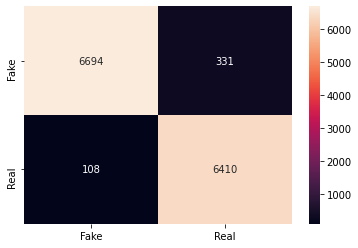

In [847]:
pred = model_full.predict_classes(X_test)
cf_matrix = confusion_matrix(y_test,pred)
sns.heatmap(cf_matrix, annot=True, fmt='g', xticklabels = ['Fake','Real'] , yticklabels = ['Fake','Real'])



---





Testing with some real world data

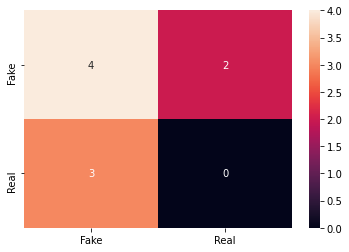

In [849]:
prediction, inp_data = results_test_function(tokenizer_full_data_w2v, model_full, stop_w=custom_stop_words)

Conclusion:


---


We can see that there is no much impact when we club the global face and real news dataset to the forward messages that have shown up in India, infact this peromed poor on the real data from whatsapp forwards of India. 

The corpus which was trained on PIB facts was itself performing very good, and once we have new corpus from PIB, the accuracy can be improved further.


In [0]:
input_msg = 'Governments roadmap to ease covid-10 restriction will be on 3 week review process, the current phases would commence on the following dates: Phase 1 - 18th May Phase 2 - 8th June Phase 3 - 29th June Phase 4 - 20th July Phase 5 - 10th August If coronavirus cases begin to increase, we will revert to restrictions set out in the previous stage'
user_message_dict = [{'text': input_msg}]
user_message_df = pd.DataFrame(user_message_dict)

In [956]:
user_message_df

,text
0,Governments roadmap to ease covid-10 restricti...
